# Lab 3: Stochastic Gradient Descent

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD3"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L3_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [36]:
from sklearn import model_selection

data = pd.read_csv("/kaggle/input/lab-3-cs-mla/w8a.csv", sep=";", header=None)

X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=32)

## Logistic Regression



Today we'll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [37]:
import sklearn.linear_model as Lmodels

log_model = Lmodels.LogisticRegression(penalty = "l2", C = 1)
log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [38]:
from sklearn.metrics import accuracy_score
print(f"accuracy= {accuracy_score(y_test,y_pred)}")

accuracy= 0.9837982701912535


### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [39]:
class StochasticLogisticRegression():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                                              Default value
    coef_         : 1-dimensional np.array, coefficients / weights                         | None                
    lambd_        : float,                  regularization parameter                       | 0.1
    lr_           : float,                  the learning rate                              | 0.001
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                            | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """
    
    def __init__(self, lambd=2, lr=1e-2, batchsize=64, gamma=0.999, beta=0.9, eps=1e-8, debias=False,
                 thresh=0.5):
        self.coef_         = None # weights
        self.lambd_        = lambd
        self.lr_           = lr
        self.bsize_        = batchsize
        self.gamma_        = gamma
        self.beta_         = beta
        self.eps_          = eps
        self.debias_       = debias
        self.coef_history_ = []
        self.f_history_    = []
        self.thresh_       = thresh

    def logistic(self, z):
        # logistic function = sigmoid
        return 1/(1+np.exp(-z))
        
    def fit(self, X, y, lr=1e-2, bsize=64, max_iter=100, minibatch=False):
        
        """ Fit the data (X, y).
    
        Parameters:
        -----------                                                                         Default value
        X          : (num_samples, num_features) np.array, Design matrix                  | 
        y          : (num_sampes, ) np.array,              Output vector                  | 
        lr         : float,                                the learning rate              | 0.001
        bsize      : integer,                              the size of the mini-batch >=1 | 64
        max_iter   : integer,                              the number of epochs           | 100
        mini_batch : bool,                                 method used                    | False
        """
        
        self.bsize_ = bsize
        self.lr_    = lr
        lambd       = self.lambd_
        n, p        = X.shape
        y           = y.reshape(n,1)
        
        self.coef_  = np.random.random((1,p))/10
        
        def f_lr(w):
            '''evaluate average loss : 1/n * F=\sum_{i=1}^n f_i in w'''
            return np.sum(np.log(1 + np.exp(-y*np.dot(X, w.T)))) + lambd*np.linalg.norm(w)**2/2
       
        def grad_f(w, batch):
            return -np.sum(y[batch]*(1-self.logistic(y[batch]*np.dot(X[batch],(w.T))))*X[batch],axis=0).reshape((1,p)) + lambd*w

        
        batch_number = int(n/self.bsize_)
        m_t          = 0
        s_t          = 0
        
        for iter in tqdm(range(max_iter)):
            
            if minibatch:                     
                l       = np.array(range(n))
                np.random.shuffle(l)
                batches = np.split(l[:-(n%batch_number)], batch_number)
                for batch in batches:
      
                    g_t        = grad_f(self.coef_, batch)
                    m_t        = (self.beta_*m_t+(1-self.beta_)*g_t)
                    s_t        = (self.gamma_*s_t+(1-self.gamma_)*g_t**2)
                    if self.debias_:
                        m_t    = m_t / (1-self.beta_**(iter+1))
                        s_t    = s_t / (1-self.gamma_**(iter+1))
                    self.coef_ = self.coef_ - lr*m_t/np.sqrt(s_t+self.eps_)
                
            else:  
                batch          = np.array(range(n))
                g_t            = grad_f(self.coef_,batch)
                m_t            = (self.beta_*m_t+(1-self.beta_)*g_t)
                s_t            = (self.gamma_*s_t+(1-self.gamma_)*g_t**2)
                if self.debias_:
                    m_t        = m_t / (1-self.beta_**(iter+1))
                    s_t        = s_t / (1-self.gamma_**(iter+1))
                self.coef_     = self.coef_ - lr*m_t/np.sqrt(s_t+self.eps_)
                
            loss               = f_lr(self.coef_)
            self.coef_history_.append(self.coef_)
            self.f_history_.append(loss)

        best_epoch = np.argmin(self.f_history_)
        best_loss  = self.f_history_[best_epoch]
        self.coef_ = self.coef_history_[best_epoch]
       

    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array, Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array, Predictions (0 or 1)
        """
        
        y_pred = self.logistic(np.dot(X,self.coef_[0].T))
        return y_pred
    
    def accuracy_evaluation(self,X,y,thresh=0.5,margin=0,vizualisation=True):
        """ Compute detailed accuracy rates.
    
        Parameters:
        -----------                                                              Default value
        X                : (num_samples, num_features) np.array, Input data    | 
        y                : (num_samples, ) np.array, Labels of the input data  | 
        thresh           : Decision threshold                                  | 0.5
        margin           : If the prediction is at a distance less than margin | 0
                           to the treshold, returns undetermined label.        |
        vizualisation    : Allow the user to vizualize in a board the results  | True
            
        Returns:
        -----
        good_prediction  : % of correct classifications
        undetermined     : % of indetermined labels 
        wrong_prediction : % of wrong classifications
        TP               : % of 1 labelled 1
        UP               : % of 1 labelled undetermined
        FN               : % of 1 labelled 0
        TN               : % of 0 labelled 0
        UN               : % of 0 labelled undetermined
        FP               : % of 0 labelled 1
        F1_score         : F1-score
        """  
        
        metrics       = {}
        y_pred        = self.predict(X)
        sample_size   = len(X)
        metrics["TP"] = 0 
        metrics["UP"] = 0
        metrics['FN'] = 0
        metrics['TN'] = 0
        metrics['UN'] = 0
        metrics['FP'] = 0
        
        for i in range(sample_size):
            
            if y[i] ==   1:
                if y_pred[i]   > thresh + margin:
                    metrics["TP"] = metrics["TP"] + 1
                    
                elif y_pred[i] < thresh - margin:
                    metrics["FN"] = metrics["FN"] + 1
                    
                else:
                    metrics["UP"] = metrics["UP"] + 1
                    
            if y[i] ==  -1:
                if y_pred[i]   < thresh - margin:
                    metrics["TN"] = metrics["TN"] + 1
                    
                elif y_pred[i] > thresh + margin:
                    metrics["FP"] = metrics["FP"] + 1
                    
                else:
                    metrics["UN"] = metrics['UN'] + 1
                    
        metrics["P"]           = metrics["TP"]  + metrics["UP"] + metrics["FN"] 
        metrics["N"]           = metrics["TN"]  + metrics["UN"] + metrics["FP"]
        metrics['TP']          = metrics['TP']  / metrics['P']
        metrics['UP']          = metrics['UP']  / metrics['P']
        metrics['FN']          = metrics['FN']  / metrics['P']
        metrics['TN']          = metrics['TN']  / metrics['N']
        metrics['UN']          = metrics['UN']  / metrics['N']
        metrics['FP']          = metrics['FP']  / metrics['N']
        metrics['good_prediction']   = (metrics['TP'] * metrics['P'] + metrics['TN'] * metrics['N'])/sample_size
        metrics['undetermined']= (metrics['UP'] * metrics['P'] + metrics['UN'] * metrics['N'])/sample_size
        metrics['wrong_prediction']  = (metrics['FP'] * metrics['N'] + metrics['FN'] * metrics['P'])/sample_size
        metrics['F1_score']    = metrics['TP']  /(metrics['TP'] + 1/2 * (metrics['FP'] + metrics['FN']))
        
        if vizualisation:
            m = metrics
            TP, FN, FP, TN = m['TP'], m['FN'], m['FP'], m['TN']
            UP, UN = m['UP'], m['UN']
            P, N = m['P'], m['N']
        
            def cell(count, denom):
                return f"{count}" if denom else f"{count} (—)"
        
            header  = ["", "Pred=1", "Pred=0", "Pred=Unkown", "Total"]
            row_pos = ["True=1", cell(TP, P), cell(FN, P), cell(UP, P), f"{P}"]
            row_neg = ["True=0", cell(FP, N), cell(TN, N), cell(UN, N), f"{N}"]
        
            col1, col0, colU, tot = TP + FP, FN + TN, UP + UN, P + N
            row_tot = ["Total", cell(col1, tot), cell(col0, tot), cell(colU, tot), f"{tot}"]
        
            colw = max(len(x) for row in [header, row_pos, row_neg, row_tot] for x in row)
        
            def fmt_row(r):
                return " | ".join(f"{c:>{colw}}" if i else f"{c:<7}" for i, c in enumerate(r))

            ################"""""" confusion matrix """"""""""##################""
            print("\nConfusion matrix (rows=true, cols=pred):")
            print(fmt_row(header))
            print("-" * len(fmt_row(header)))
            print(fmt_row(row_pos))
            print(fmt_row(row_neg))
            print("-" * len(fmt_row(header)))
            print(fmt_row(row_tot))
        
            print(f"\nAccuracy={m['good_prediction']}  Undetermined={m['undetermined']}  "
                  f"Error={m['wrong_prediction']}  F1={m['F1_score']}")
    
                
        return metrics
    
    def find_thresh(self, X, y, step=0.01,margin=0):
        """Find the decision threshsold that maximize the f1_score
        
        Parameters:
        -----------                                                    Default value
        X      : (num_samples, num_features) np.array, Input data    | 
        y      : (num_samples, ) np.array, Labels of the input data  | 
        step   : Decision threshold                                  | 0.5
        margin : If the prediction is at a distance less than margin | 0
                 to the treshold, returns undetermined label.        |
        """  
    
        nb_steps   = int(1/step)
        thresholds = np.linspace(0,1,num=nb_steps)
        f_scores   = []
        
        for thresh in tqdm(thresholds):
            metrics_i = self.accuracy_evaluation(X,y,thresh,margin,vizualisation=False)
            f_scores.append(metrics_i["F1_score"])
            
        f_scores = np.array(f_scores)
        best_thresh = step*np.argmax(f_scores)
        plt.plot(thresholds, f_scores)
        plt.xlabel("threshold")
        plt.ylabel("F1")
        plt.show()
        print('maximum f1: ', f_scores.max())
        print('best threshold : ', best_thresh)
        self.thresh_ = best_thresh

Apply to the data

On essaie plusieurs entraînements avec différents coefficients de régularisation, on choisit celui qui minimise
l'erreur sur le test set. On entraine sur 1000 itérations en batch gradient descent. On garde **lambda = 2**.
On essaie ensuite plusieurs learning rates, on choisit le plus grand qui permet d'obtenir un gradient qui converge. On garde **lr = 0.01**.

## Optimal threshold

100%|██████████| 100/100 [00:02<00:00, 37.70it/s]


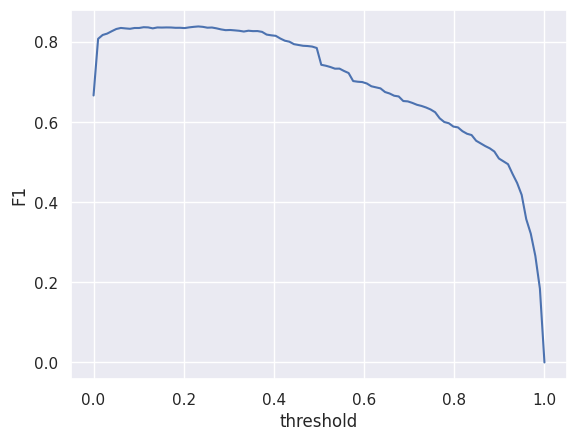

maximum f1:  0.8390704161311319
best threshold :  0.23

Confusion matrix (rows=true, cols=pred):
        |              Pred=1 |              Pred=0 |         Pred=Unkown |               Total
-----------------------------------------------------------------------------------------------
True=1  |  0.8285714285714286 | 0.17142857142857143 |                 0.0 |                 945
True=0  | 0.14549496696103253 |  0.8545050330389674 |                 0.0 |               32386
-----------------------------------------------------------------------------------------------
Total   |  0.9740663955324611 |   1.025933604467539 |                 0.0 |               33331

Accuracy=0.8537697638834718  Undetermined=0.0  Error=0.14623023611652816  F1=0.8394564949249741


{'TP': 0.8285714285714286,
 'UP': 0.0,
 'FN': 0.17142857142857143,
 'TN': 0.8545050330389674,
 'UN': 0.0,
 'FP': 0.14549496696103253,
 'P': 945,
 'N': 32386,
 'good_prediction': 0.8537697638834718,
 'undetermined': 0.0,
 'wrong_prediction': 0.14623023611652816,
 'F1_score': 0.8394564949249741}

In [40]:
#TODO
log_reg = StochasticLogisticRegression()
log_reg.fit(X_train,y_train)
log_reg.find_thresh(X_train,y_train)
log_reg.accuracy_evaluation(X_train,y_train,thresh=log_reg.thresh_)

**answer** First, allowing an **“undetermined”** label lets us examine how prediction errors are distributed around the decision threshold. For example, if the threshold is 0.6, we can tell whether most errors are +1 cases whose predicted score is just below 0.6, or whether errors are more uniformly spread (e.g., a false negative is as likely to have a score of 0.58 as of 0.10). Note that the closer errors are to the threshold, the lower the loss. Here, the false positives appear to be uniformly distributed.

Second, the training set is highly imbalanced: there are many more −1 examples (32,386) than +1 examples (945). As a result, predicting −1 most of the time already yields high overall accuracy, and it suffices for the dot product (w \cdot x) to be very negative to minimize the loss. The algorithm can detect this after only a few batches, hence the rapid convergence of the loss to its final value. However, minimizing the loss is not the same as maximizing metrics such as the F1-score, which account for class imbalance. It would therefore be sensible to penalize mistakes on minority-class examples more heavily, or to construct batches that oversample the +1 label so their contribution to the loss is comparable to that of the −1 examples.

We observe that the model’s accuracy is low—slightly below 80%—which is poor given that a naïve classifier always predicting −1 would reach 97%. That said, performance is similar on the training and test sets, indicating we have avoided overfitting. Moreover, precision is comparable across the two classes, so the minority class has not been neglected.

Finally, we do not enable the **debias** (bias-correction) term, because it causes the loss to increase dramatically, yielding a model that systematically predicts +1.


## Training of the model

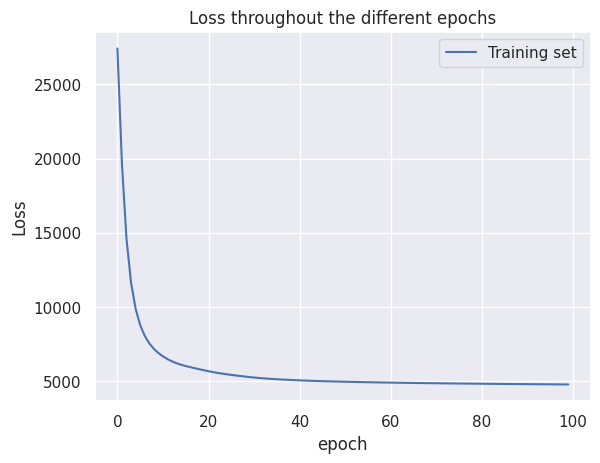

In [41]:
#TODO
nb_epochs=100
plt.plot(range(nb_epochs), log_reg.f_history_,label="Training set")
plt.title('Loss throughout the different epochs')
plt.legend()

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

Implement only one acceleration method and compare the results

## Study of the batchsize impact

In [42]:
#TODO : Study the loss
log_reg = StochasticLogisticRegression()
log_reg.fit(X_train,y_train,max_iter=nb_epochs)

log_reg_Light = StochasticLogisticRegression()
log_reg_Light.fit(X_train,y_train, bsize=8,max_iter=nb_epochs, minibatch=True)


log_reg_mid = StochasticLogisticRegression()
log_reg_mid.fit(X_train,y_train, bsize=64,max_iter=nb_epochs, minibatch=True)

log_reg_Heavy = StochasticLogisticRegression()
log_reg_Heavy.fit(X_train,y_train, bsize=256,max_iter=nb_epochs, minibatch=True)

log_reg_VHeavy = StochasticLogisticRegression()
log_reg_VHeavy.fit(X_train,y_train, bsize=1024,max_iter=nb_epochs, minibatch=True)

100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


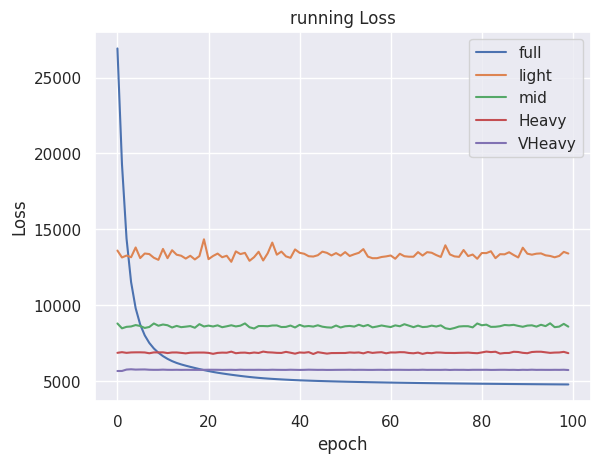

In [43]:
plt.plot(range(nb_epochs), log_reg.f_history_,label="full")
plt.plot(range(nb_epochs), log_reg_Light.f_history_,label="light")
plt.plot(range(nb_epochs), log_reg_mid.f_history_,label="mid")
plt.plot(range(nb_epochs), log_reg_Heavy.f_history_,label="Heavy")
plt.plot(range(nb_epochs), log_reg_VHeavy.f_history_,label="VHeavy")

plt.title('running Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()


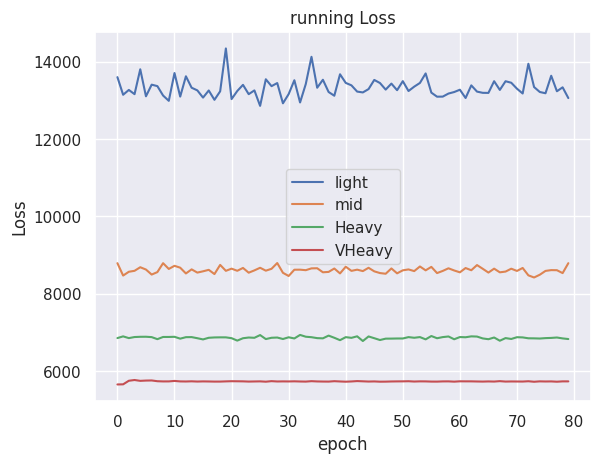

In [44]:
plt.plot(range(nb_epochs)[:80], log_reg_Light.f_history_[:80],label="light")
plt.plot(range(nb_epochs)[:80], log_reg_mid.f_history_[:80],label="mid")
plt.plot(range(nb_epochs)[:80], log_reg_Heavy.f_history_[:80],label="Heavy")
plt.plot(range(nb_epochs)[:80], log_reg_VHeavy.f_history_[:80],label="VHeavy")

plt.title('running Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()


**answer** We conclude that when the batch size is too large, the behavior approaches standard full-batch gradient descent. With a sufficient number of medium-sized mini-batches, convergence is accelerated. By contrast, very small mini-batches can prevent the algorithm from learning. This is explained by the low proportion of +1 labels in the dataset: with tiny batches, many may contain only −1 labels, which biases the updates.

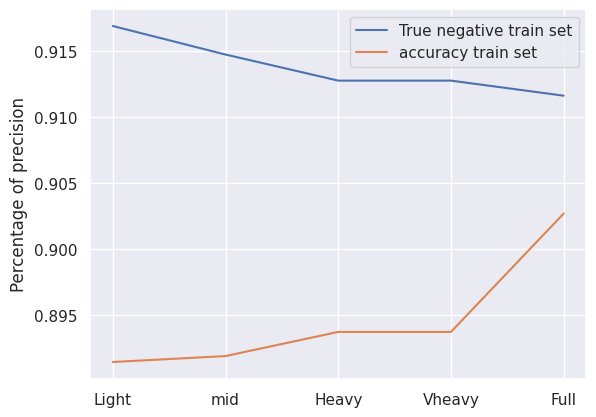

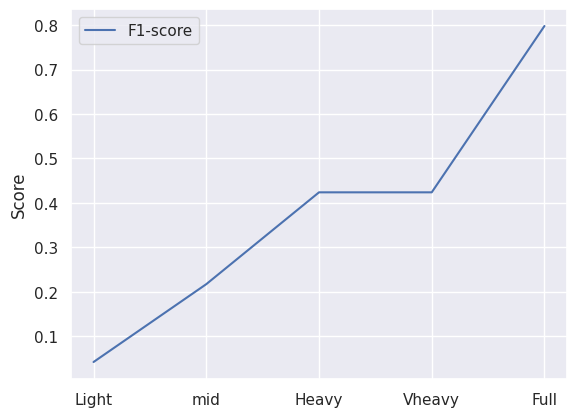

In [45]:
#TODO : Study the accuracy
metrics_train_Light=log_reg_Light.accuracy_evaluation(X_train,y_train,thresh=log_reg_Light.thresh_,vizualisation=False)
metrics_test_Light=log_reg_Light.accuracy_evaluation(X_test,y_test,thresh=log_reg_Light.thresh_,vizualisation=False)

metrics_train_mid=log_reg_mid.accuracy_evaluation(X_train,y_train,thresh=log_reg_mid.thresh_,vizualisation=False)
metrics_test_mid=log_reg_mid.accuracy_evaluation(X_test,y_test,thresh=log_reg_mid.thresh_,vizualisation=False)

metrics_train_Heavy=log_reg_Heavy.accuracy_evaluation(X_train,y_train,thresh=log_reg_Heavy.thresh_,vizualisation=False)
metrics_test_Heavy=log_reg_Heavy.accuracy_evaluation(X_test,y_test,thresh=log_reg_Heavy.thresh_,vizualisation=False)

metrics_train_VHeavy=log_reg_Heavy.accuracy_evaluation(X_train,y_train,thresh=log_reg_VHeavy.thresh_,vizualisation=False)
metrics_test_VHeavy=log_reg_Heavy.accuracy_evaluation(X_test,y_test,thresh=log_reg_VHeavy.thresh_,vizualisation=False)

metrics_train=log_reg.accuracy_evaluation(X_train,y_train,thresh=log_reg.thresh_,vizualisation=False)
metrics_test=log_reg.accuracy_evaluation(X_test,y_test,thresh=log_reg.thresh_,vizualisation=False)

TN = [metrics_train_Light["TN"] ,metrics_train_mid["TN"] ,metrics_train_Heavy["TN"],metrics_train_VHeavy["TN"],metrics_train["TN"]]

#TP = [metrics_train_Light["TP"] ,metrics_train_mid["TP"] ,metrics_train_Heavy["TP"],metrics_train_VHeavy["TP"],metrics_train_Heavy["TP"]]

good_prediction = [metrics_train_Light["good_prediction"] ,metrics_train_mid["good_prediction"] ,metrics_train_Heavy["good_prediction"],metrics_train_VHeavy["good_prediction"],metrics_train["good_prediction"]]

F1_score  = [metrics_train_Light["F1_score"] ,metrics_train_mid["F1_score"] ,metrics_train_Heavy["F1_score"],metrics_train_VHeavy["F1_score"],metrics_train["F1_score"]]

plt.plot(["Light","mid","Heavy","Vheavy","Full"], TN,label="True negative train set")
#plt.plot(["Light","mid","Heavy","Vheavy","Full"], TP,label="True positive train set")
plt.plot(["Light","mid","Heavy","Vheavy","Full"], good_prediction,label="accuracy train set")
plt.legend()

plt.ylabel('Percentage of precision')
plt.show()

plt.plot(["Light","mid","Heavy","Vheavy","Full"], F1_score,label="F1-score")
plt.legend()

plt.ylabel('Score')
plt.show()


**answer** Prediction quality tends to decline as batch size grows—reflecting the classic trade-off: mini-batches accelerate convergence but add variance and noise to the updates. When batches become very small, performance on the +1 class degrades in particular, since tiny batches are more likely to contain only −1 labels, which skews the gradients.

In short: very large batches behave like full-batch gradient descent; a sufficient number of medium-sized batches speeds learning; very small batches can stall it under class imbalance.

## Gamma impact

In [46]:
#TODO : Study Loss and F1-score
log_reg = StochasticLogisticRegression()
log_reg.fit(X_train,y_train, bsize=256,max_iter=nb_epochs, minibatch=True)

log_reg_90 = StochasticLogisticRegression(gamma=0.90)
log_reg_90.fit(X_train,y_train, bsize=256,max_iter=nb_epochs, minibatch=True)

log_reg_75 = StochasticLogisticRegression(gamma=0.75)
log_reg_75.fit(X_train,y_train, bsize=256,max_iter=nb_epochs, minibatch=True)

log_reg_50 = StochasticLogisticRegression(gamma=0.50)
log_reg_50.fit(X_train,y_train, bsize=256,max_iter=nb_epochs, minibatch=True)


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


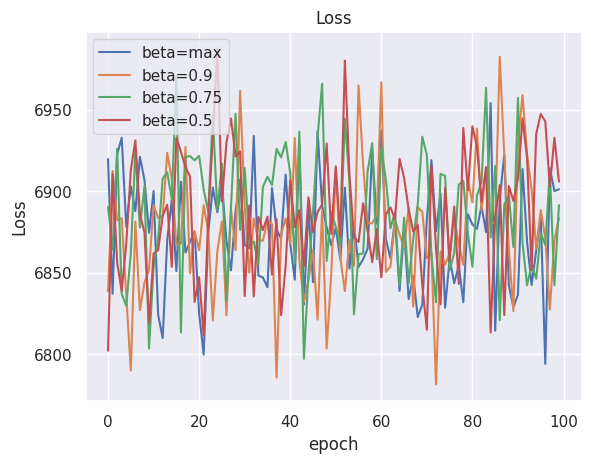

In [47]:
plt.plot(range(nb_epochs), log_reg.f_history_,label="beta=max")
plt.plot(range(nb_epochs), log_reg_90.f_history_,label="beta=0.9")
plt.plot(range(nb_epochs), log_reg_75.f_history_,label="beta=0.75")
plt.plot(range(nb_epochs), log_reg_50.f_history_,label="beta=0.5")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

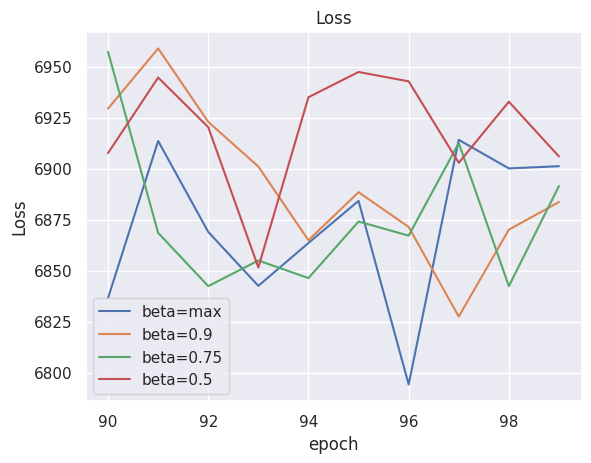

In [48]:
plt.plot(range(nb_epochs)[90:], log_reg.f_history_[90:],label="beta=max")
plt.plot(range(nb_epochs)[90:], log_reg_90.f_history_[90:],label="beta=0.9")
plt.plot(range(nb_epochs)[90:], log_reg_75.f_history_[90:],label="beta=0.75")
plt.plot(range(nb_epochs)[90:], log_reg_50.f_history_[90:],label="beta=0.5")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


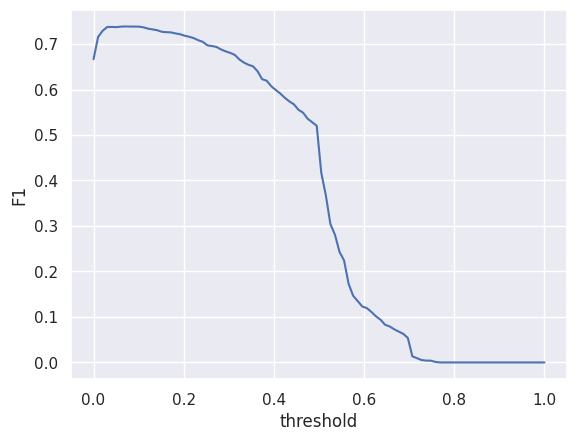

maximum f1:  0.7386092837560787
best threshold :  0.07


100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


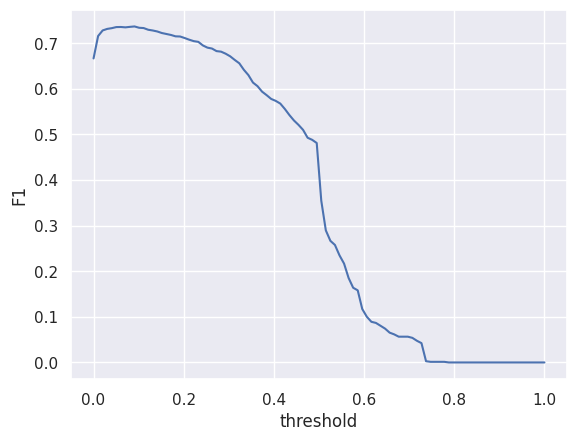

maximum f1:  0.7368038145926356
best threshold :  0.09


100%|██████████| 100/100 [00:03<00:00, 25.77it/s]


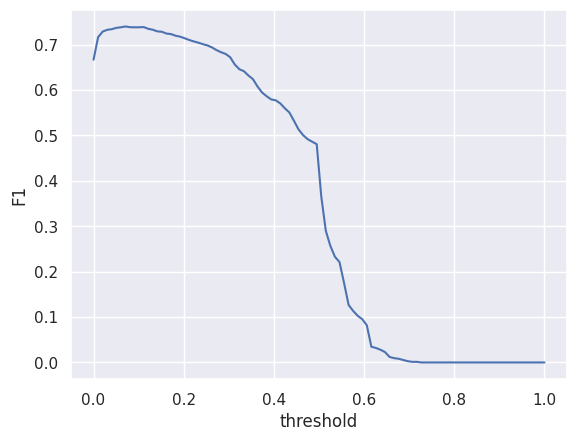

maximum f1:  0.7398862337723392
best threshold :  0.07


100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


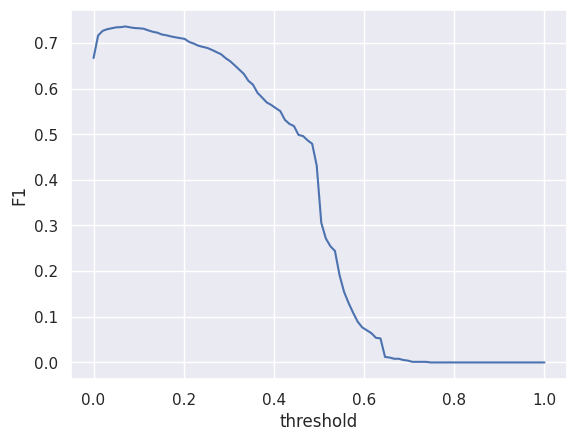

maximum f1:  0.7359360436919884
best threshold :  0.07


In [49]:
algos = [log_reg,log_reg_90, log_reg_75, log_reg_50]
metrics = []
for algo in algos:
    algo.find_thresh(X,y)
    metrics.append(algo.accuracy_evaluation(X,y,thresh=algo.thresh_, vizualisation=False))

**answer** The loss curves are broadly similar, and the effect is modest.

## Beta impact
Nous allons comparer les paramètres beta pour gamma = 0.999 et batch_size=1024

In [50]:
#TODO : Study Loss and F1-score
log_reg_09 = StochasticLogisticRegression(beta=0.9)
log_reg_09.fit(X_train,y_train, bsize=1024,max_iter=nb_epochs, minibatch=True)

log_reg_075 = StochasticLogisticRegression(debias=False,beta=0.75)
log_reg_075.fit(X_train,y_train, bsize=1024,max_iter=nb_epochs, minibatch=True)

log_reg_05 = StochasticLogisticRegression(debias=False, gamma=0.5)
log_reg_05.fit(X_train,y_train, bsize=1024,max_iter=nb_epochs, minibatch=True)

100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


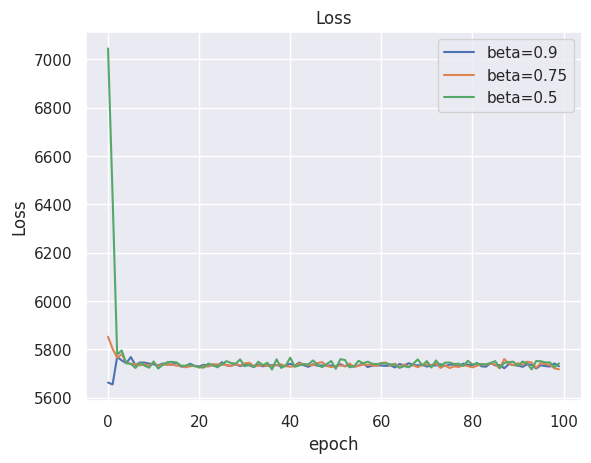

In [51]:

plt.plot(list(range(len(log_reg_09.f_history_))), log_reg_09.f_history_,label="beta=0.9")
plt.plot(list(range(len(log_reg_075.f_history_))), log_reg_075.f_history_,label="beta=0.75")
plt.plot(list(range(len(log_reg_05.f_history_))), log_reg_05.f_history_,label="beta=0.5")

plt.title('Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

100%|██████████| 100/100 [00:03<00:00, 26.07it/s]


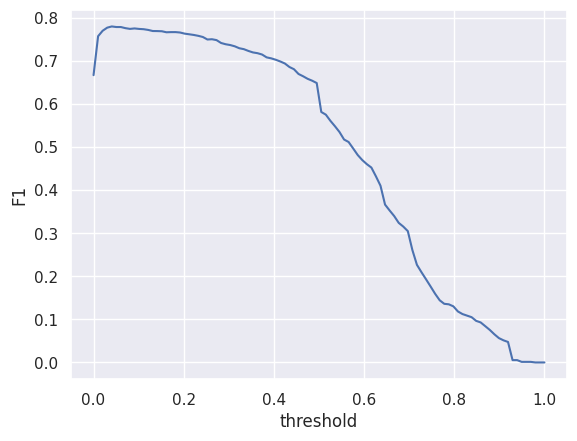

maximum f1:  0.7797076114082099
best threshold :  0.04


100%|██████████| 100/100 [00:03<00:00, 26.20it/s]


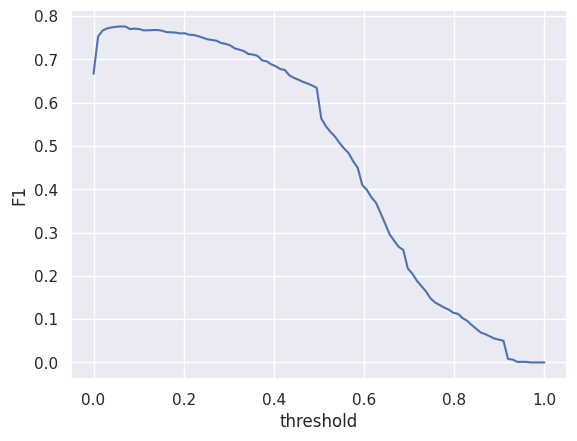

maximum f1:  0.7759789309940919
best threshold :  0.06


100%|██████████| 100/100 [00:03<00:00, 25.97it/s]


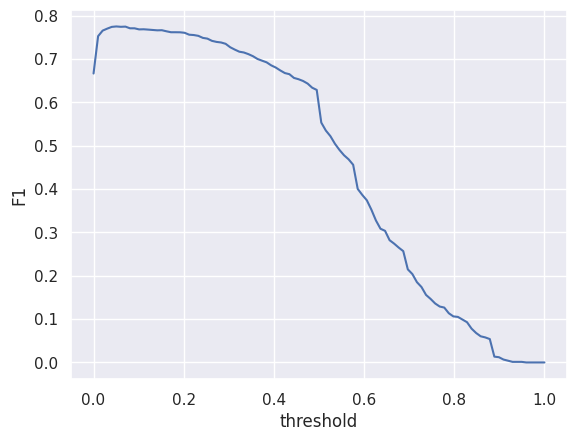

maximum f1:  0.7752794962539795
best threshold :  0.05


In [52]:
algos = [log_reg_09, log_reg_075, log_reg_05]
metrics = []
for algo in algos:
    algo.find_thresh(X,y)
    metrics.append(algo.accuracy_evaluation(X,y,thresh=algo.thresh_, vizualisation=False))

**answer** The loss curves are broadly similar; parameter values above 0.90 appear to converge slightly faster, but the effect is modest.